# Building Graph Neural Networks

In [3]:
%pip install rdkit
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install torch torchvision torchaudio
%pip install torch-geometric

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
import pickle
import torch
from torch import nn
from torch.optim import Adam
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool
import numpy as np
from rdkit import Chem
from torch_geometric.utils import from_smiles
import pandas as pd
from sklearn.metrics import roc_auc_score
from IPython.display import HTML, display

CONFIG = {
    'data_dir': './processed_tox21',
    'hidden_channels': 128,
    'num_layers': 3,
    'dropout': 0.2,
    'batch_size': 64,
    'lr': 1e-3,
    'weight_decay': 0,
    'epochs': 50,
    'patience': 8,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

# Automatically detects if you have a GPU
print(f"Using device: {CONFIG['device']}")


/home/goisaiah/Visual Studio Code Projects/ToxicityPredictor/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


Load data from preprocessing

In [6]:
def load_split(name):
    path = os.path.join(CONFIG['data_dir'], f'tox21_{name}.pkl')
    with open(path, 'rb') as f:
        data = pickle.load(f)
    return data


data_train = load_split('train')
data_validation = load_split('validation')
data_test = load_split('test')

print(f"Train: {len(data_train['smiles'])} | Validation: {len(data_validation['smiles'])} | Test: {len(data_test['smiles'])}")

Train: 6258 | Validation: 782 | Test: 783


Convert SMILES to GNNs

In [7]:
def build_graph(smi, labels):
    try:
        data = from_smiles(smi)
        labels = np.array(labels, dtype=float).reshape(-1)
        data.y = torch.tensor(labels, dtype=torch.float).unsqueeze(0)
        return data
    except Exception:
        return None


def make_dataset(smiles_list, label_matrix):
    dataset = []
    for smi, lbl in zip(smiles_list, label_matrix):
        g = build_graph(smi, lbl)
        if g is not None:
            dataset.append(g)
    
    return dataset

In [8]:
train_dataset = make_dataset(data_train['smiles'], data_train['labels'])
validation_dataset = make_dataset(data_validation['smiles'], data_validation['labels'])
test_dataset = make_dataset(data_test['smiles'], data_test['labels'])

print(f"Graphs Data")
print(f"Train: {len(train_dataset)} | Validation: {len(validation_dataset)} | Test: {len(test_dataset)}")

Graphs Data
Train: 6258 | Validation: 782 | Test: 783


In [9]:
train_loader = DataLoader(train_dataset, batch_size = CONFIG['batch_size'], shuffle = True)
val_loader = DataLoader(validation_dataset, batch_size = CONFIG['batch_size'])
test_loader = DataLoader(test_dataset, batch_size = CONFIG['batch_size'])

Double checking the dimensions of the dataset

In [10]:
# After rebuilding the dataset and re-creating train_dataset, etc.
sample = train_dataset[0]
print("single graph -- x:", sample.x.shape, "y:", sample.y.shape, "num_nodes:", sample.num_nodes)

batch = next(iter(train_loader))
print("batch.x:", batch.x.shape)
print("batch.batch:", batch.batch.shape, "max batch index:", batch.batch.max().item())
print("batch.y:", batch.y.shape)   # should be (batch_size, num_tasks)

single graph -- x: torch.Size([14, 9]) y: torch.Size([1, 12]) num_nodes: 14
batch.x: torch.Size([1247, 9])
batch.batch: torch.Size([1247]) max batch index: 63
batch.y: torch.Size([64, 12])


Class for GNN Models

In [11]:
class GNNModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, model_type='GCN', num_layers=3, dropout=0.2):
        super().__init__()
        self.model_type = model_type
        self.convs = nn.ModuleList()
        if model_type == 'GCN':
            # Aggregates information from neighboring atoms
            self.convs.append(GCNConv(in_channels, hidden_channels))
            for _ in range(num_layers-1):
                self.convs.append(GCNConv(hidden_channels, hidden_channels))
        elif model_type == 'GAT':
            # Learns to weight each neighbour
            self.convs.append(GATConv(in_channels, hidden_channels, heads=4, concat=False))
            for _ in range(num_layers-1):
                self.convs.append(GATConv(hidden_channels, hidden_channels, heads=4, concat=False))
        else:
            raise ValueError("model_type must be 'GCN' or 'GAT'")
        
        self.dropout = dropout
        self.lin = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_channels//2, out_channels)
        )

    def forward(self, x, edge_index, batch):
        for conv in self.convs:
            x = conv(x, edge_index)
            x = torch.relu(x)
            x = nn.functional.dropout(x, p=self.dropout, training=self.training)
        x = global_mean_pool(x, batch)
        return self.lin(x)
    
    def forward_with_attention(self, x, edge_index, batch):
        # Only returns attention weights for the first GAT layer
        if self.model_type != 'GAT':
            raise ValueError("forward_with_attention is only available for GAT models")
        
        x = x.float()
        x, (attn_edge_index, attn_values) = self.convs[0](x, edge_index, return_attention_weights=True)
        x = torch.relu(x)
        x = nn.functional.dropout(x, p=self.dropout, training=self.training)
        
        for conv in self.convs[1:]:
            x = conv(x, edge_index)
            x = torch.relu(x)
            x = nn.functional.dropout(x, p=self.dropout, training=self.training)

        x = global_mean_pool(x, batch)
        out = self.lin(x)
        return out, attn_edge_index, attn_values

Training and Evaluation Functions

In [12]:
def masked_bce_loss(logits, labels):
    """
    logits: (batch_size, num_tasks)
    labels: (batch_size, num_tasks) some NaNs
    """
    # mask indicates which label positions are valid (not NaN)
    mask = ~torch.isnan(labels)

    if mask.sum() == 0:
        return torch.tensor(0.0, device=logits.device)
    
    valid_logits = logits[mask]
    valid_labels = labels[mask]
    loss = nn.BCEWithLogitsLoss()(valid_logits, valid_labels)
    return loss

In [13]:
def train_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0.0
    for data in loader:
        data.x = data.x.to(torch.float)
        data.edge_index = data.edge_index.to(torch.long)
        if hasattr(data, "edge_attr") and data.edge_attr is not None:
            data.edge_attr = data.edge_attr.to(torch.float)
        data.y = data.y.to(torch.float)

        data = data.to(device)

        optimizer.zero_grad()
        logits = model(data.x, data.edge_index, data.batch)

        loss = masked_bce_loss(logits, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

In [14]:
def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for data in loader:
            data.x = data.x.to(torch.float)
            data.edge_index = data.edge_index.to(torch.long)
            if hasattr(data, "edge_attr") and data.edge_attr is not None:
                data.edge_attr = data.edge_attr.to(torch.float)
            data.y = data.y.to(torch.float)

            data = data.to(device)
            
            logits = model(data.x, data.edge_index, data.batch)

            if data.y.dim() == 1:
                data.y = data.y.view(-1, logits.size(1))

            loss = masked_bce_loss(logits, data.y)
            total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

Train and Evaluate GNNs

In [15]:
sample_graph = train_dataset[0]
in_channels = sample_graph.x.shape[1]
out_channels = sample_graph.y.shape[1]
results = {}
results_rows = []
roc_rows = []

for model_type in ['GCN', 'GAT']:
    print(f"Training {model_type}")
    model = GNNModel(
        in_channels=in_channels,
        hidden_channels=CONFIG['hidden_channels'],
        out_channels=out_channels,
        model_type=model_type,
        num_layers=CONFIG['num_layers'],
        dropout=CONFIG['dropout']
    ).to(CONFIG['device'])

    optimizer = Adam(model.parameters(), lr=CONFIG['lr'], weight_decay=CONFIG['weight_decay'])
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(1, CONFIG['epochs']+1):
        train_loss = train_epoch(model, train_loader, optimizer, CONFIG['device'])
        val_loss = evaluate(model, val_loader, CONFIG['device'])

        results_rows.append({
            "Model": model_type,
            "Epoch": epoch,
            "Train Loss": round(train_loss, 4),
            "Val Loss": round(val_loss, 4)
        })

        print(f"{model_type} | Epoch {epoch:03d} Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f"best_{model_type}.pt")
        else:
            patience_counter += 1
            if patience_counter >= CONFIG['patience']:
                print(f"Early stopping {model_type}")
                break
    
    model.load_state_dict(torch.load(f"best_{model_type}.pt"))
    test_loss = evaluate(model, test_loader, CONFIG['device'])
    print(f"{model_type} Test Loss: {test_loss:.4f}")

    results_rows.append({
        "Model": model_type,
        "Epoch": "Best",
        "Train Loss": None,
        "Val Loss": round(test_loss, 4),
    })

    results[model_type] = {'val_loss': best_val_loss, 'test_loss': test_loss}
    

print("Summary of training:")
print("Model | Val Loss | Test Loss")
for model_type, res in results.items():
    print(f"{model_type:4s} | {res['val_loss']:.4f} | {res['test_loss']:.4f}")

Training GCN
GCN | Epoch 001 Train Loss: 0.3065 | Val Loss: 0.2488
GCN | Epoch 002 Train Loss: 0.2537 | Val Loss: 0.2429
GCN | Epoch 003 Train Loss: 0.2471 | Val Loss: 0.2400
GCN | Epoch 004 Train Loss: 0.2446 | Val Loss: 0.2408
GCN | Epoch 005 Train Loss: 0.2416 | Val Loss: 0.2334
GCN | Epoch 006 Train Loss: 0.2375 | Val Loss: 0.2356
GCN | Epoch 007 Train Loss: 0.2388 | Val Loss: 0.2306
GCN | Epoch 008 Train Loss: 0.2345 | Val Loss: 0.2281
GCN | Epoch 009 Train Loss: 0.2338 | Val Loss: 0.2284
GCN | Epoch 010 Train Loss: 0.2319 | Val Loss: 0.2270
GCN | Epoch 011 Train Loss: 0.2331 | Val Loss: 0.2262
GCN | Epoch 012 Train Loss: 0.2318 | Val Loss: 0.2261
GCN | Epoch 013 Train Loss: 0.2298 | Val Loss: 0.2262
GCN | Epoch 014 Train Loss: 0.2292 | Val Loss: 0.2249
GCN | Epoch 015 Train Loss: 0.2300 | Val Loss: 0.2252
GCN | Epoch 016 Train Loss: 0.2297 | Val Loss: 0.2280
GCN | Epoch 017 Train Loss: 0.2276 | Val Loss: 0.2228
GCN | Epoch 018 Train Loss: 0.2279 | Val Loss: 0.2241
GCN | Epoch 019

In [16]:
def display_scrollable_df(df, height):
    html = df.to_html()
    display(HTML(
        f'<div style="max-height:{height}px; overflow-y:auto; border:1px solid #ddd; padding:10px;">{html}</div>'
    ))

In [17]:
results_df = pd.DataFrame(results_rows)
display_scrollable_df(results_df, height=500)

,Model,Epoch,Train Loss,Val Loss
0,GCN,1,0.3065,0.2488
1,GCN,2,0.2537,0.2429
2,GCN,3,0.2471,0.2400
3,GCN,4,0.2446,0.2408
4,GCN,5,0.2416,0.2334
5,GCN,6,0.2375,0.2356
6,GCN,7,0.2388,0.2306
7,GCN,8,0.2345,0.2281
8,GCN,9,0.2338,0.2284
9,GCN,10,0.2319,0.2270


AUC-ROC

In [18]:
def compute_task_auc(model, loader, device):
    model.eval()
    all_logits = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data.x = data.x.to(torch.float)
            data.edge_index = data.edge_index.to(torch.long)
            if hasattr(data, "edge_attr") and data.edge_attr is not None:
                data.edge_attr = data.edge_attr.to(torch.float)
            data.y = data.y.to(torch.float)

            data = data.to(device)

            logits = model(data.x, data.edge_index, data.batch)
            labels = data.y

            all_logits.append(logits.cpu())
            all_labels.append(labels.cpu())

    logits = torch.cat(all_logits, dim=0)
    labels = torch.cat(all_labels, dim=0)

    logits = logits.numpy()
    labels = labels.numpy()

    aucs = []
    for task_idx in range(labels.shape[1]):
        valid = ~np.isnan(labels[:, task_idx])
        if valid.sum() > 0:
            aucs.append(roc_auc_score(labels[valid, task_idx], logits[valid, task_idx]))
        else:
            aucs.append(np.nan)

    return aucs


In [19]:
task_names = data_train['labels_cols']

gcn_model = GNNModel(
    in_channels=in_channels,
    hidden_channels=CONFIG['hidden_channels'],
    out_channels=out_channels,
    model_type='GCN',
    num_layers=CONFIG['num_layers'],
    dropout=CONFIG['dropout']
).to(CONFIG['device'])
gcn_model.load_state_dict(torch.load("best_GCN.pt"))

gat_model = GNNModel(
    in_channels=in_channels,
    hidden_channels=CONFIG['hidden_channels'],
    out_channels=out_channels,
    model_type='GAT',
    num_layers=CONFIG['num_layers'],
    dropout=CONFIG['dropout']
).to(CONFIG['device'])
gat_model.load_state_dict(torch.load("best_GAT.pt"))

gcn_auc = compute_task_auc(gcn_model, test_loader, CONFIG['device'])
gat_auc = compute_task_auc(gat_model, test_loader, CONFIG['device'])

roc_df = pd.DataFrame({
    'Task': task_names,
    'GCN AUC-ROC': gcn_auc,
    'GAT AUC-ROC': gat_auc
})

display_scrollable_df(roc_df, height=500)

,Task,GCN AUC-ROC,GAT AUC-ROC
0,NR-AR,0.780041,0.761909
1,NR-AR-LBD,0.847428,0.869697
2,NR-AhR,0.829954,0.828090
3,NR-Aromatase,0.757319,0.708425
4,NR-ER,0.646725,0.662804
5,NR-ER-LBD,0.751548,0.813149
6,NR-PPAR-gamma,0.808653,0.844084
7,SR-ARE,0.691475,0.689199
8,SR-ATAD5,0.738514,0.757135
9,SR-HSE,0.714843,0.751107


In [20]:
batch = next(iter(test_loader))
print("x:", batch.x.shape)
print("y:", batch.y.shape)
print("batch:", batch.batch.shape)


x: torch.Size([1173, 9])
y: torch.Size([64, 12])
batch: torch.Size([1173])


# GCN vs GAT

In [21]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


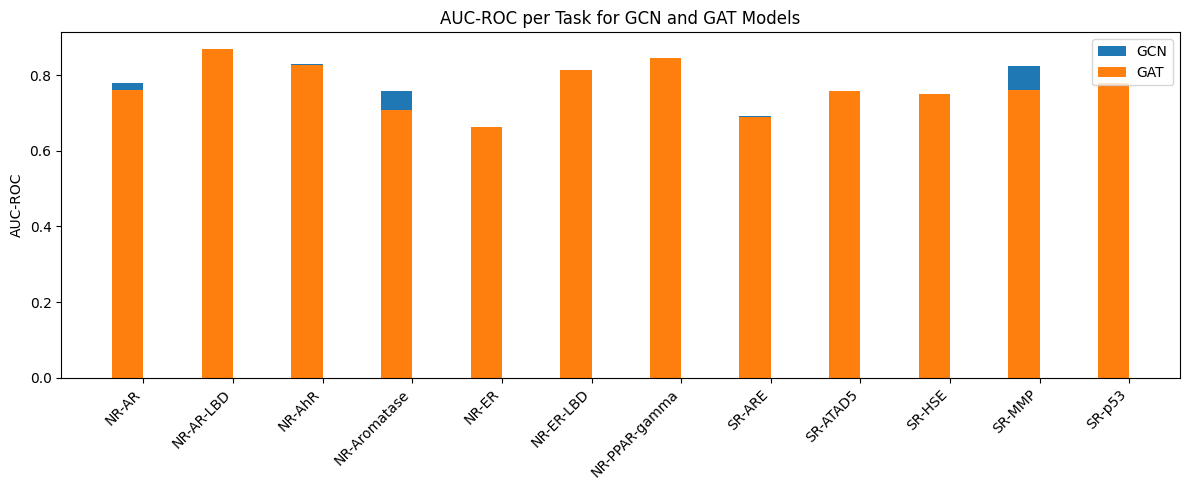

In [22]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12,5))
x = np.arange(len(roc_df))
width = 0.35
plt.bar(x - width/2, roc_df['GCN AUC-ROC'], width, label='GCN')
plt.bar(x - width/2, roc_df['GAT AUC-ROC'], width, label='GAT')

plt.xticks(x, roc_df['Task'], rotation=45, ha='right')
plt.ylabel('AUC-ROC')
plt.title('AUC-ROC per Task for GCN and GAT Models')
plt.legend()
plt.tight_layout()
plt.show()

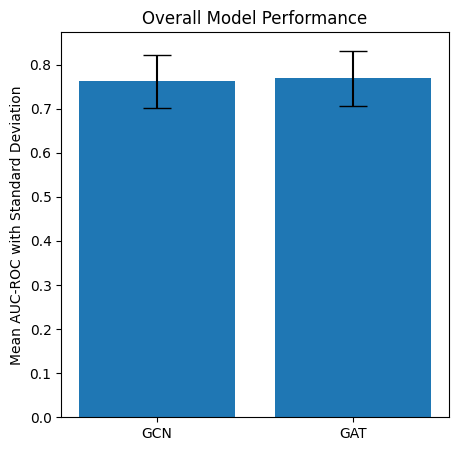

In [23]:
mean_gcn = roc_df['GCN AUC-ROC'].mean() 
std_gcn = roc_df['GCN AUC-ROC'].std()
mean_gat = roc_df['GAT AUC-ROC'].mean() 
std_gat = roc_df['GAT AUC-ROC'].std()

plt.figure(figsize=(5,5))
plt.bar(['GCN', 'GAT'], [mean_gcn, mean_gat], yerr=[std_gcn, std_gat], capsize=10)
plt.ylabel('Mean AUC-ROC with Standard Deviation')
plt.title('Overall Model Performance')
plt.show()

# GAT Visualization

In [24]:
%pip install rdkit

Note: you may need to restart the kernel to use updated packages.


In [25]:
from rdkit.Chem import Draw
from rdkit import Chem

def atom_attention_scores(edge_index, attn, num_nodes):
    if attn.dim() == 2:
        attn = attn.mean(dim=1)

    scores = torch.zeros(num_nodes, dtype=torch.float)

    for (i, j), a in zip(edge_index.t(), attn):
        scores[i] += a
        scores[j] += a

    scores = scores / (scores.max() + 1e-8) # Normalize to [0, 1]
    return scores


def draw_attention(smiles, scores):
    mol = Chem.MolFromSmiles(smiles)
    atom_colors = {i: (0.0, 0.0, float(scores[i])) for i in range(len(scores))}

    return Draw.MolToImage(mol, highlightAtoms=list(atom_colors.keys()), highlightAtomColors=atom_colors, size=(350, 350))

Example using 1 molecule

/tmp/ipykernel_4365/3502556728.py:20: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  atom_colors = {i: (0.0, 0.0, float(scores[i])) for i in range(len(scores))}


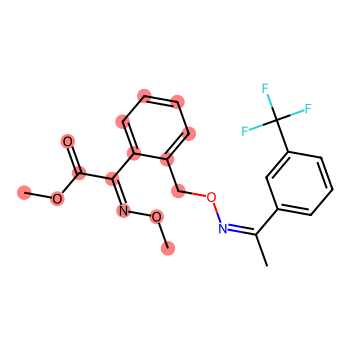

In [26]:
gat_model.eval()
data = test_dataset[0].to(CONFIG['device'])
logits, edge_index, attn = gat_model.forward_with_attention(data.x, data.edge_index, data.batch)
scores = atom_attention_scores(edge_index, attn, data.x.size(0))

img = draw_attention(data_test['smiles'][7], scores)
img

In [27]:
def visualize_topk_attention(model, dataset, smiles_list, k=9):
    model.eval()
    scores_list = []

    for i, data in enumerate(dataset):
        data = data.to(CONFIG['device'])
        with torch.no_grad():
            logits, edge_index, attn = model.forward_with_attention(data.x, data.edge_index, data.batch)
        scores = atom_attention_scores(edge_index, attn, data.x.size(0))
        scores_list.append((i, scores.mean().item())) # Mean attention score per molecule

    # Pick top-k molecules with highest mean attention scores
    topk_indices = [idx for idx, _ in sorted(scores_list, key=lambda x: x[1], reverse=True)[:k]]

    plt.figure(figsize=(12, 12))
    for j, idx in enumerate(topk_indices):
        data = dataset[idx].to(CONFIG['device'])
        logits, edge_index, attn = model.forward_with_attention(data.x, data.edge_index, data.batch)
        scores = atom_attention_scores(edge_index, attn, data.x.size(0))
        img = draw_attention(smiles_list[idx], scores)
        plt.subplot(int(np.ceil(k/3)), 3, j+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Molecule {idx}")
    plt.tight_layout()
    plt.show()

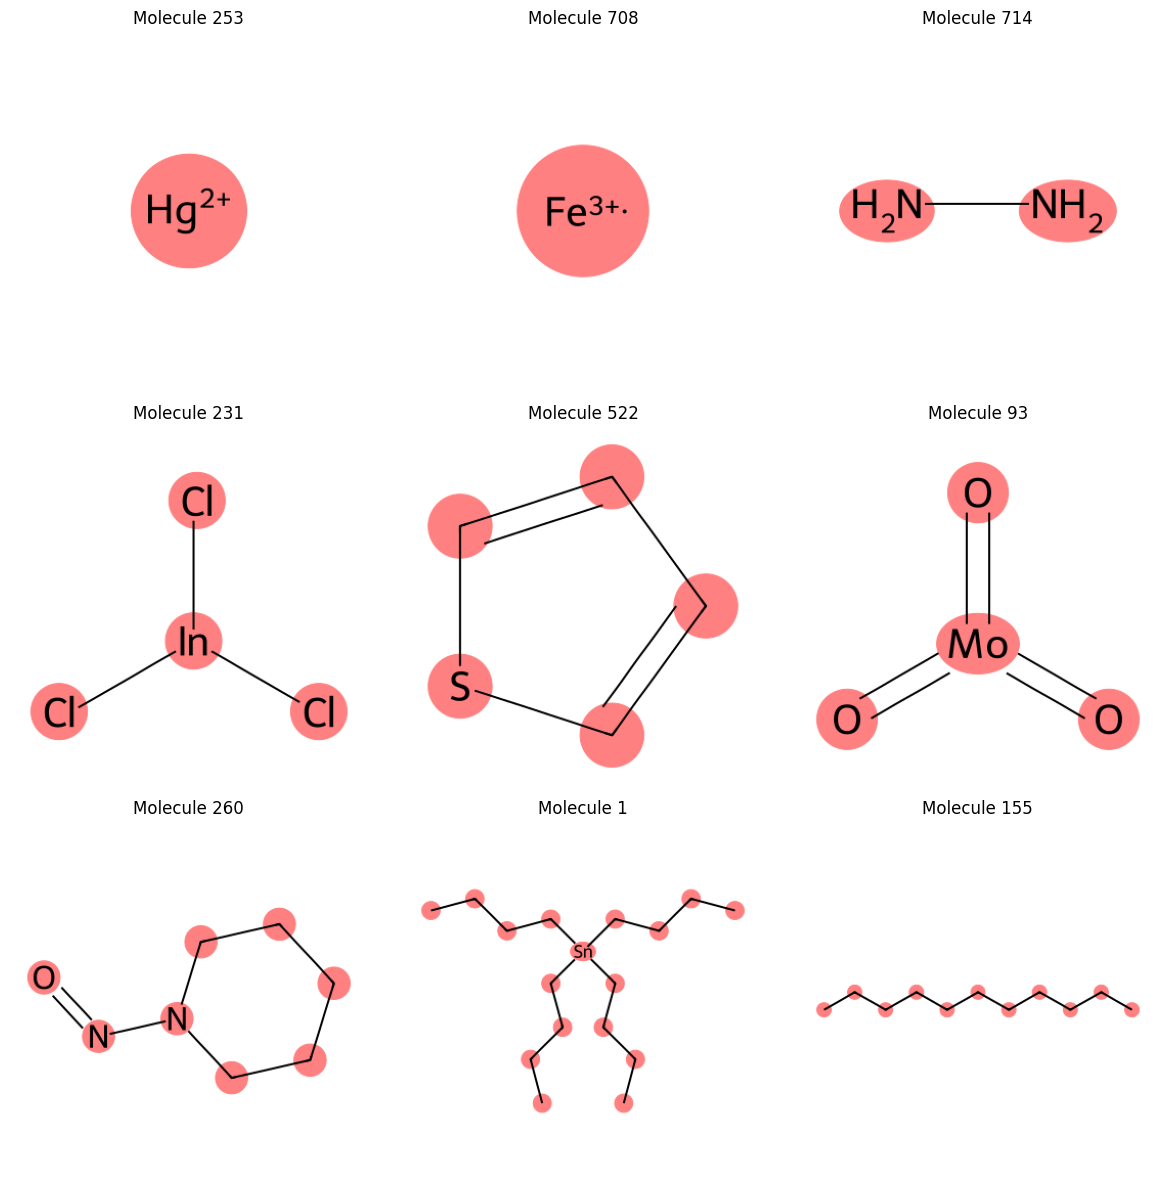

In [28]:
visualize_topk_attention(gat_model, test_dataset, data_test['smiles'], k=9)

Highlighting Functional Substructures (SMARTS Patterns)

In [29]:
TOXICOPHORE_SMARTS = {
    "Nitro group": "[NX3](=O)=O",
    "Aromatic amine": "a[NX3;H2,H1;!$(NC=0)]",
    "Halogen": "[F,Cl,Br,I]",
    "Hydroxyl": "[OX2H]",
    "Carboxylic acid": "C(=O)[OX2H1]",
    "Ester": "C(=O)O",
    "Carbonyl": "C=O",
    "Amide": "C(=O)N",
    "Phenol": "c1ccc(O)cc1",
    "Aniline": "c1ccc(N)cc1"
}


def find_substructure_atoms(smiles, smarts_library):
    mol = Chem.MolFromSmiles(smiles)
    highlight_atoms = {}
    for name, smarts in smarts_library.items():
        patt = Chem.MolFromSmarts(smarts)
        if patt is None:
            continue
        matches = mol.GetSubstructMatches(patt)
        if matches:
            atom_ids = sorted({a for match in matches for a in match})
            highlight_atoms[name] = atom_ids
    return highlight_atoms

In [31]:
smil = data_test['smiles'][521]
highlight_atoms = find_substructure_atoms(smil, TOXICOPHORE_SMARTS)
print(highlight_atoms)

{'Ester': [12, 13, 14], 'Carbonyl': [5, 6, 12, 13]}


In [34]:
def draw_attention_with_substructures(smiles, atom_scores, substructures):
    mol = Chem.MolFromSmiles(smiles)
    atom_scores = atom_scores / (atom_scores.max() + 1e-6)

    # Normalize red intensity for atoms (attention)
    atom_scores = {i: (1.0, 1.0 - atom_scores[i], 1.0 - atom_scores[i]) for i in range(len(atom_scores))}

    # Highlight substructures with distinct colors
    palette = [
        (0.6, 0.8, 1.0),  # light blue
        (0.8, 1.0, 0.6),  # light green
        (1.0, 0.8, 0.4),  # light orange
        (0.9, 0.6, 1.0),  # light purple
    ]

    highlight_dict = {}
    for i, (name, atom_ids) in enumerate(substructures.items()):
        color = palette[i % len(palette)]
        for atom_id in atom_ids:
            highlight_dict[atom_id] = color
    
    drawer = Draw.MolDraw2DCairo(400, 300)
    Draw.rdMolDraw2D.PrepareAndDrawMolecule(
        drawer, mol,
        highlightAtoms=list(highlight_dict.keys()),
        highlightAtomColors=highlight_dict,
    )
    drawer.FinishDrawing()
    return drawer.GetDrawingText()

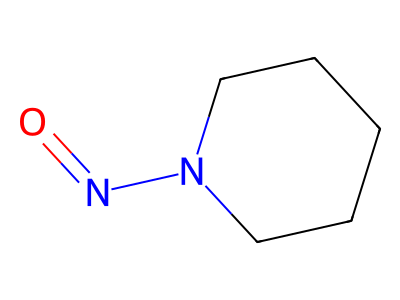

In [38]:
highlight_atoms = find_substructure_atoms(data_test['smiles'][260], TOXICOPHORE_SMARTS)
img_bytes = draw_attention_with_substructures(data_test['smiles'][260], scores, highlight_atoms)

from IPython.display import Image
Image(data=img_bytes)